# Setup Model

In [1]:
import torch
from typing import cast
from ultralytics import YOLO
from transformers.utils.import_utils import is_flash_attn_2_available
from colpali_engine.models.paligemma.colpali.processing_colpali import ColPaliProcessor
from colpali_engine.models import ColQwen2_5, ColQwen2_5_Processor
from sentence_transformers import SentenceTransformer

# Define the device
device = "cuda:0"

# YOLO-12L-Doclaynet
yolo_model = YOLO("pretrained_models/yolo-doclaynet/yolov12l-doclaynet.pt")
yolo_model = yolo_model.to(device)

# ColQwen2.5-Colpali
colpali_model = ColQwen2_5.from_pretrained(
        "pretrained_models/colqwen2.5-v0.2",
        torch_dtype=torch.bfloat16,
        device_map=device,  # or "mps" if on Apple Silicon
        attn_implementation="flash_attention_2" if is_flash_attn_2_available() else None,
    ).eval()
colpali_processor = ColQwen2_5_Processor.from_pretrained("pretrained_models/colqwen2.5-v0.2")
processor = cast(
    ColPaliProcessor, 
    colpali_processor)

# Mxbai-embed-large-v1
embed_model = SentenceTransformer("pretrained_models/mxbai-embed-large-v1",device=device)

# Define Entity Colors
ENTITIES_COLORS = {
    "Picture": (255, 72, 88),
    "Table": (128, 0, 128)
}

print("FINISH SETUP...")

/mnt/hdd/soohwan/anaconda3/envs/indexing_pipeline/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Loading checkpoint shards: 100%|██████████| 2/2 [00:03<00:00,  1.56s/it]
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


FINISH SETUP...


# Helper Functions

In [3]:
import matplotlib.pyplot as plt
import cv2

def display_img_array(img_arr):
    image_rgb = cv2.cvtColor(img_arr, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(30, 30))
    plt.imshow(image_rgb)
    plt.axis('off')
    plt.show()

In [4]:
import matplotlib.pyplot as plt
import cv2

def show_layout_detection(detection_results, img_arr):
    for result in detection_results:
        boxes = result.boxes # Get detection boxes
        for box in boxes:
            x, y, w, h = box.xywh[0]  # Box coordinates (center x, y, width, height)
            x, y, w, h = int(x), int(y), int(w), int(h) # Convert to integers
            conf = box.conf.item()  # Confidence score
            cls = int(box.cls.item())  # Class ID
            label = f"{yolo_model.model.names[cls]} {conf:.2f}"
            color = ENTITIES_COLORS[yolo_model.model.names[cls]] # Get the color for this class
            top_left = (x - w // 2, y - h // 2)
            bottom_right = (x + w // 2, y + h // 2) # Class-specific colored box
            cv2.rectangle(img_arr, top_left, bottom_right, color, 2)
            cv2.putText(img_arr, label, (top_left[0], top_left[1] - 10),  cv2.FONT_HERSHEY_SIMPLEX, 0.9, color, 2) # Matching text color
    display_img_array(img_arr)

# Indexing Pipeline

In [2]:

# Define knowledge base sources and target image directory
document_source_dir = "document_sources"
filename = "SLB-2023-Annual-Report.pdf"
page_id = 40
img_dir = "image_database"
os.makedirs(img_dir, exist_ok=True) # Ensure the directory exists

### Extracting Pictures, Tables, and Texts

##### Open Image

In [3]:
import fitz  # PyMuPDF
import numpy as np
import cv2
import os

doc = fitz.open(os.path.join(document_source_dir,filename))
page = doc.load_page(page_id)  # Page index is 0-based
pix = page.get_pixmap(dpi=300)
img_rgb = np.frombuffer(pix.samples, dtype=np.uint8).reshape((pix.height, pix.width, pix.n))
img_page = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2BGR)

In [4]:
doc.page_count

76

##### Layout Detection


0: 1024x800 1 Picture, 2 Tables, 29.2ms
Speed: 32.7ms preprocess, 29.2ms inference, 2.1ms postprocess per image at shape (1, 3, 1024, 800)


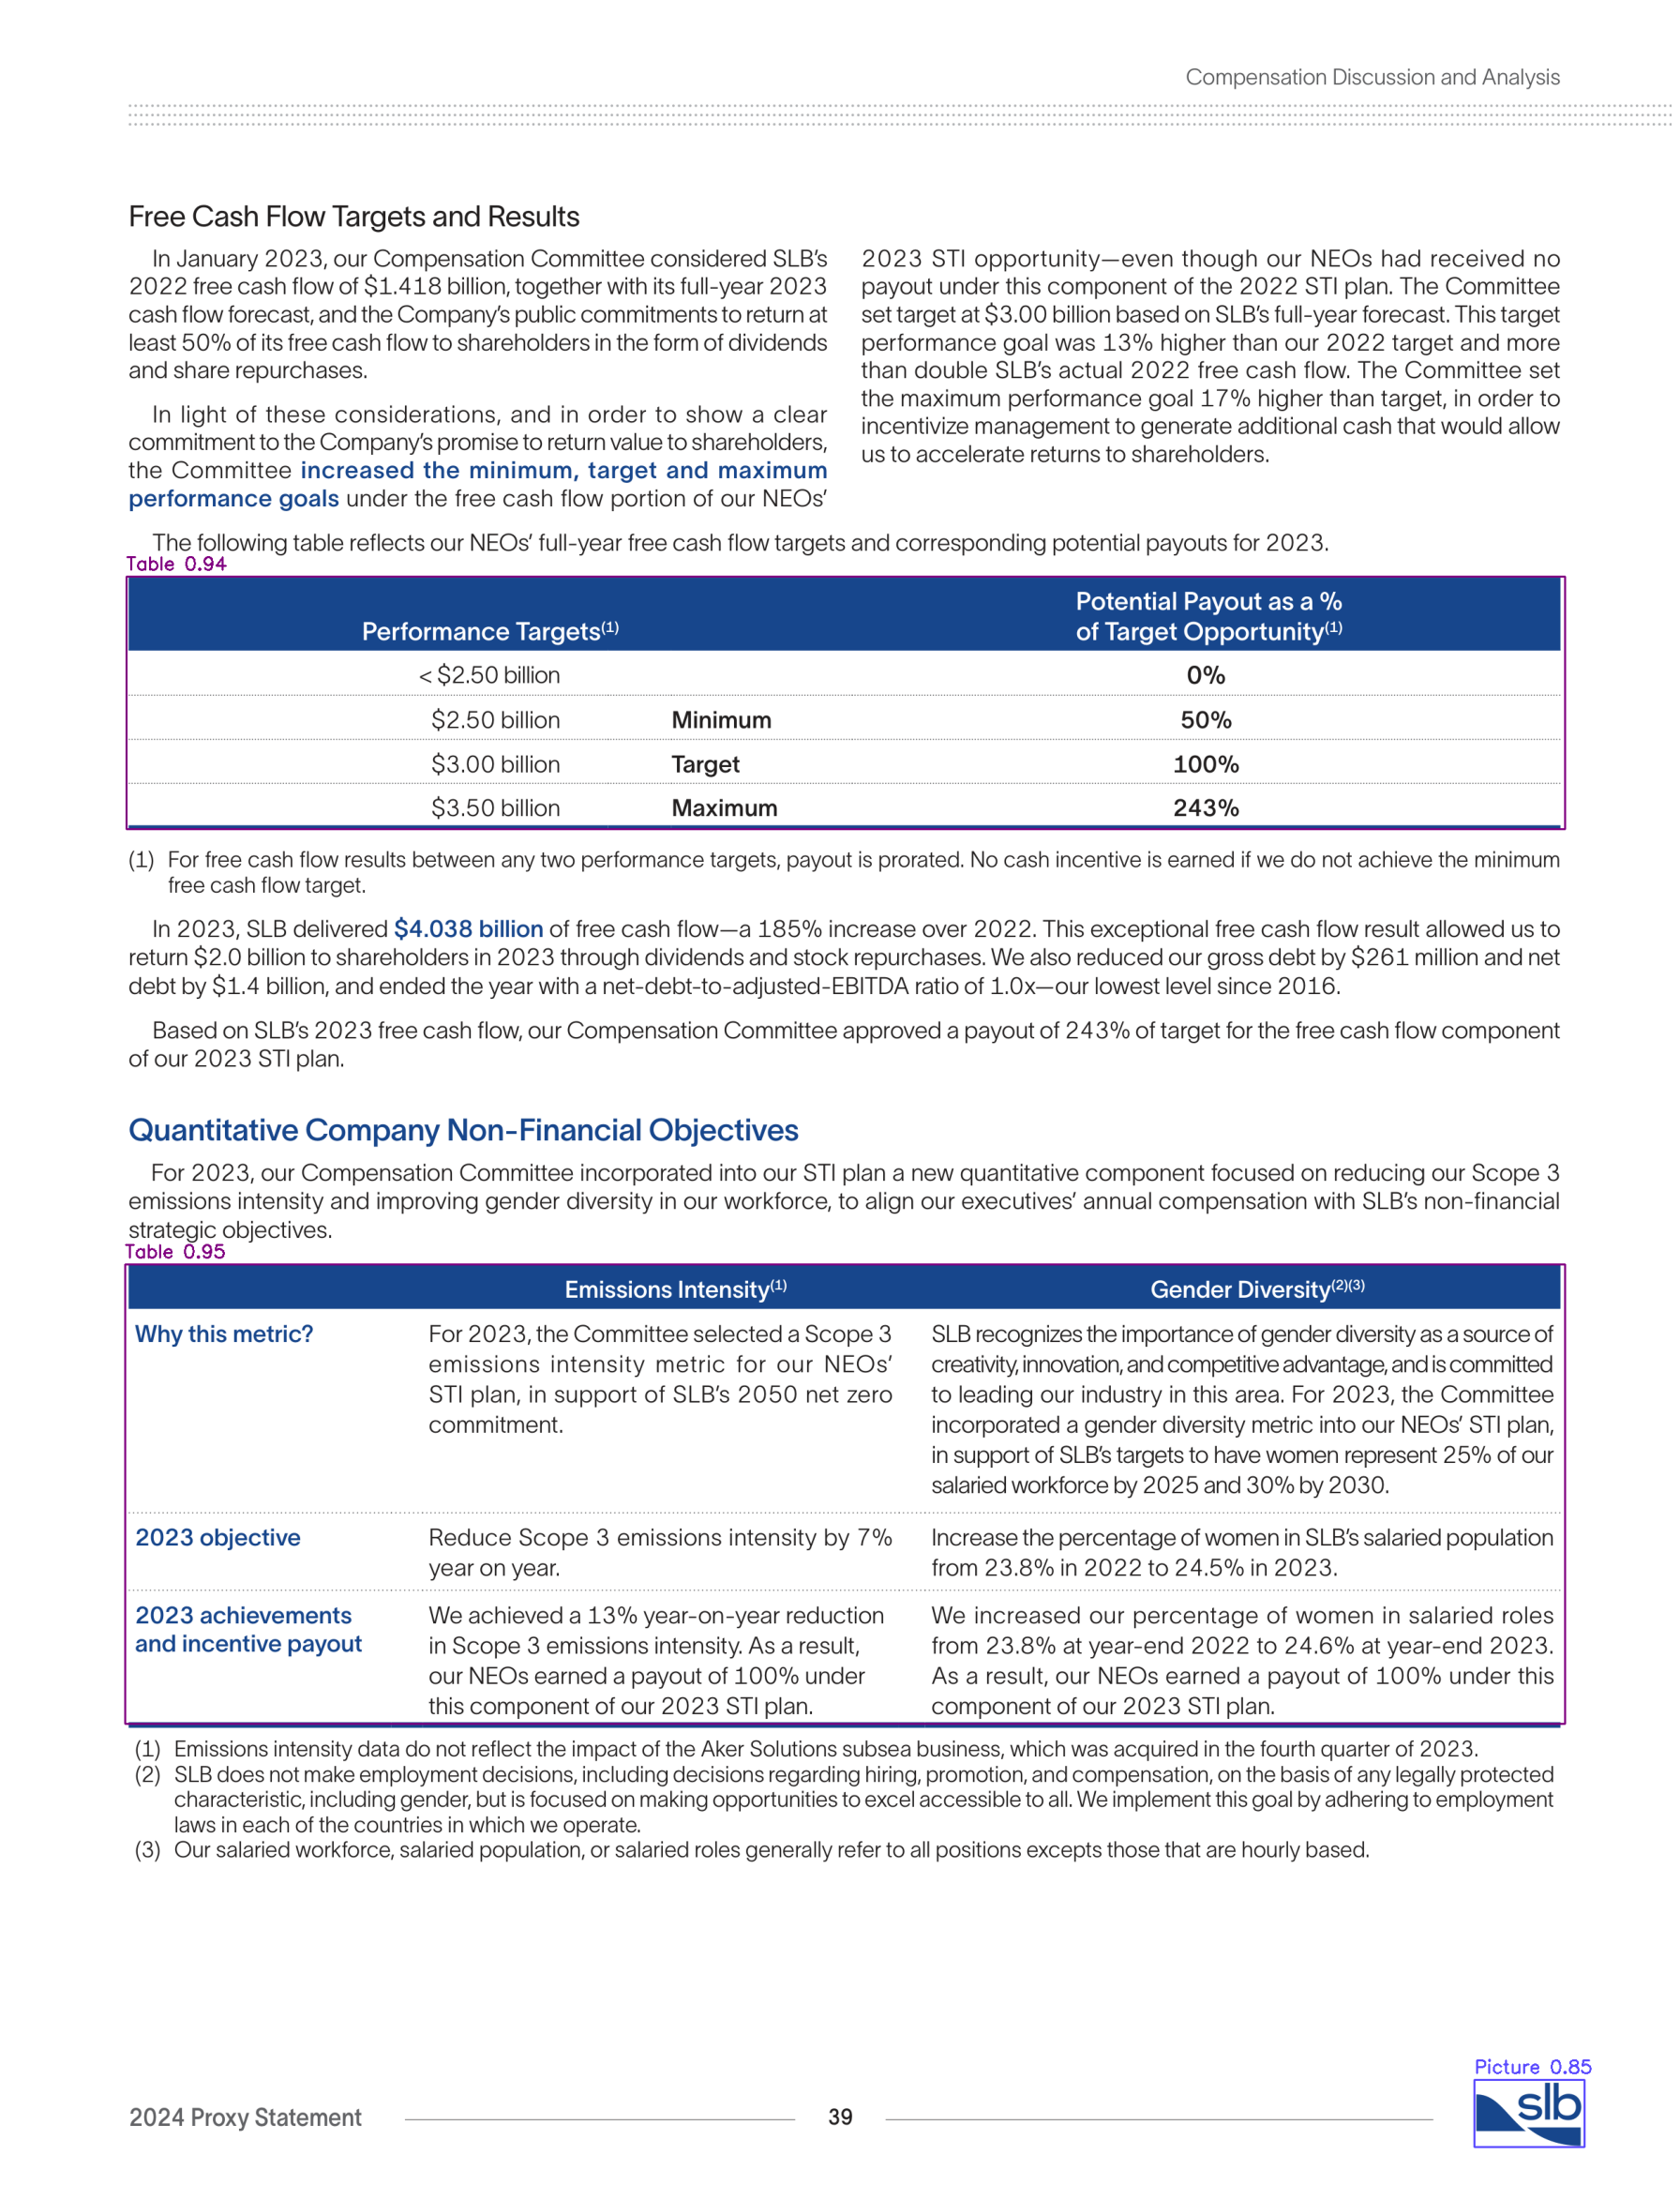

In [12]:
def layout_detection(img_doc):
    return yolo_model.predict(
        source=img_doc, 
        classes=[6,8],
        conf=0.25, 
        iou=0.45)

layout_results = layout_detection(img_page)
show_layout_detection(layout_results, img_page)

##### Extracting Detected Layout

In [14]:
def extract_and_masking_images(img_doc, layout_results):
    height, width, _ = img_doc.shape
    extracted_imgs = []
    for box in layout_results[0].boxes:
        x, y, w, h = map(int,box.xywh[0])  # Box coordinates (center x, y, width, height)
        # Calculate top-left corner (x_min, y_min)
        x_min = x - w // 2
        y_min = y - h // 2
        x_max = x_min + w
        y_max = y_min + h
        # Clamp coordinates to image boundaries
        x_start = max(0, x_min)
        y_start = max(0, y_min)
        x_end = min(width, x_max)
        y_end = min(height, y_max)
        # Skip if region is invalid
        if x_start >= x_end or y_start >= y_end:
            continue
        # Extract the image to the array of extracted_imgs
        extracted_imgs.append(img_doc[y_start:y_end, x_start:x_end].copy())
        # Set region to white
        img_doc[y_start:y_end, x_start:x_end] = [255, 255, 255]
    return extracted_imgs, img_doc

extracted_imgs, img_page = extract_and_masking_images(img_page, layout_results)

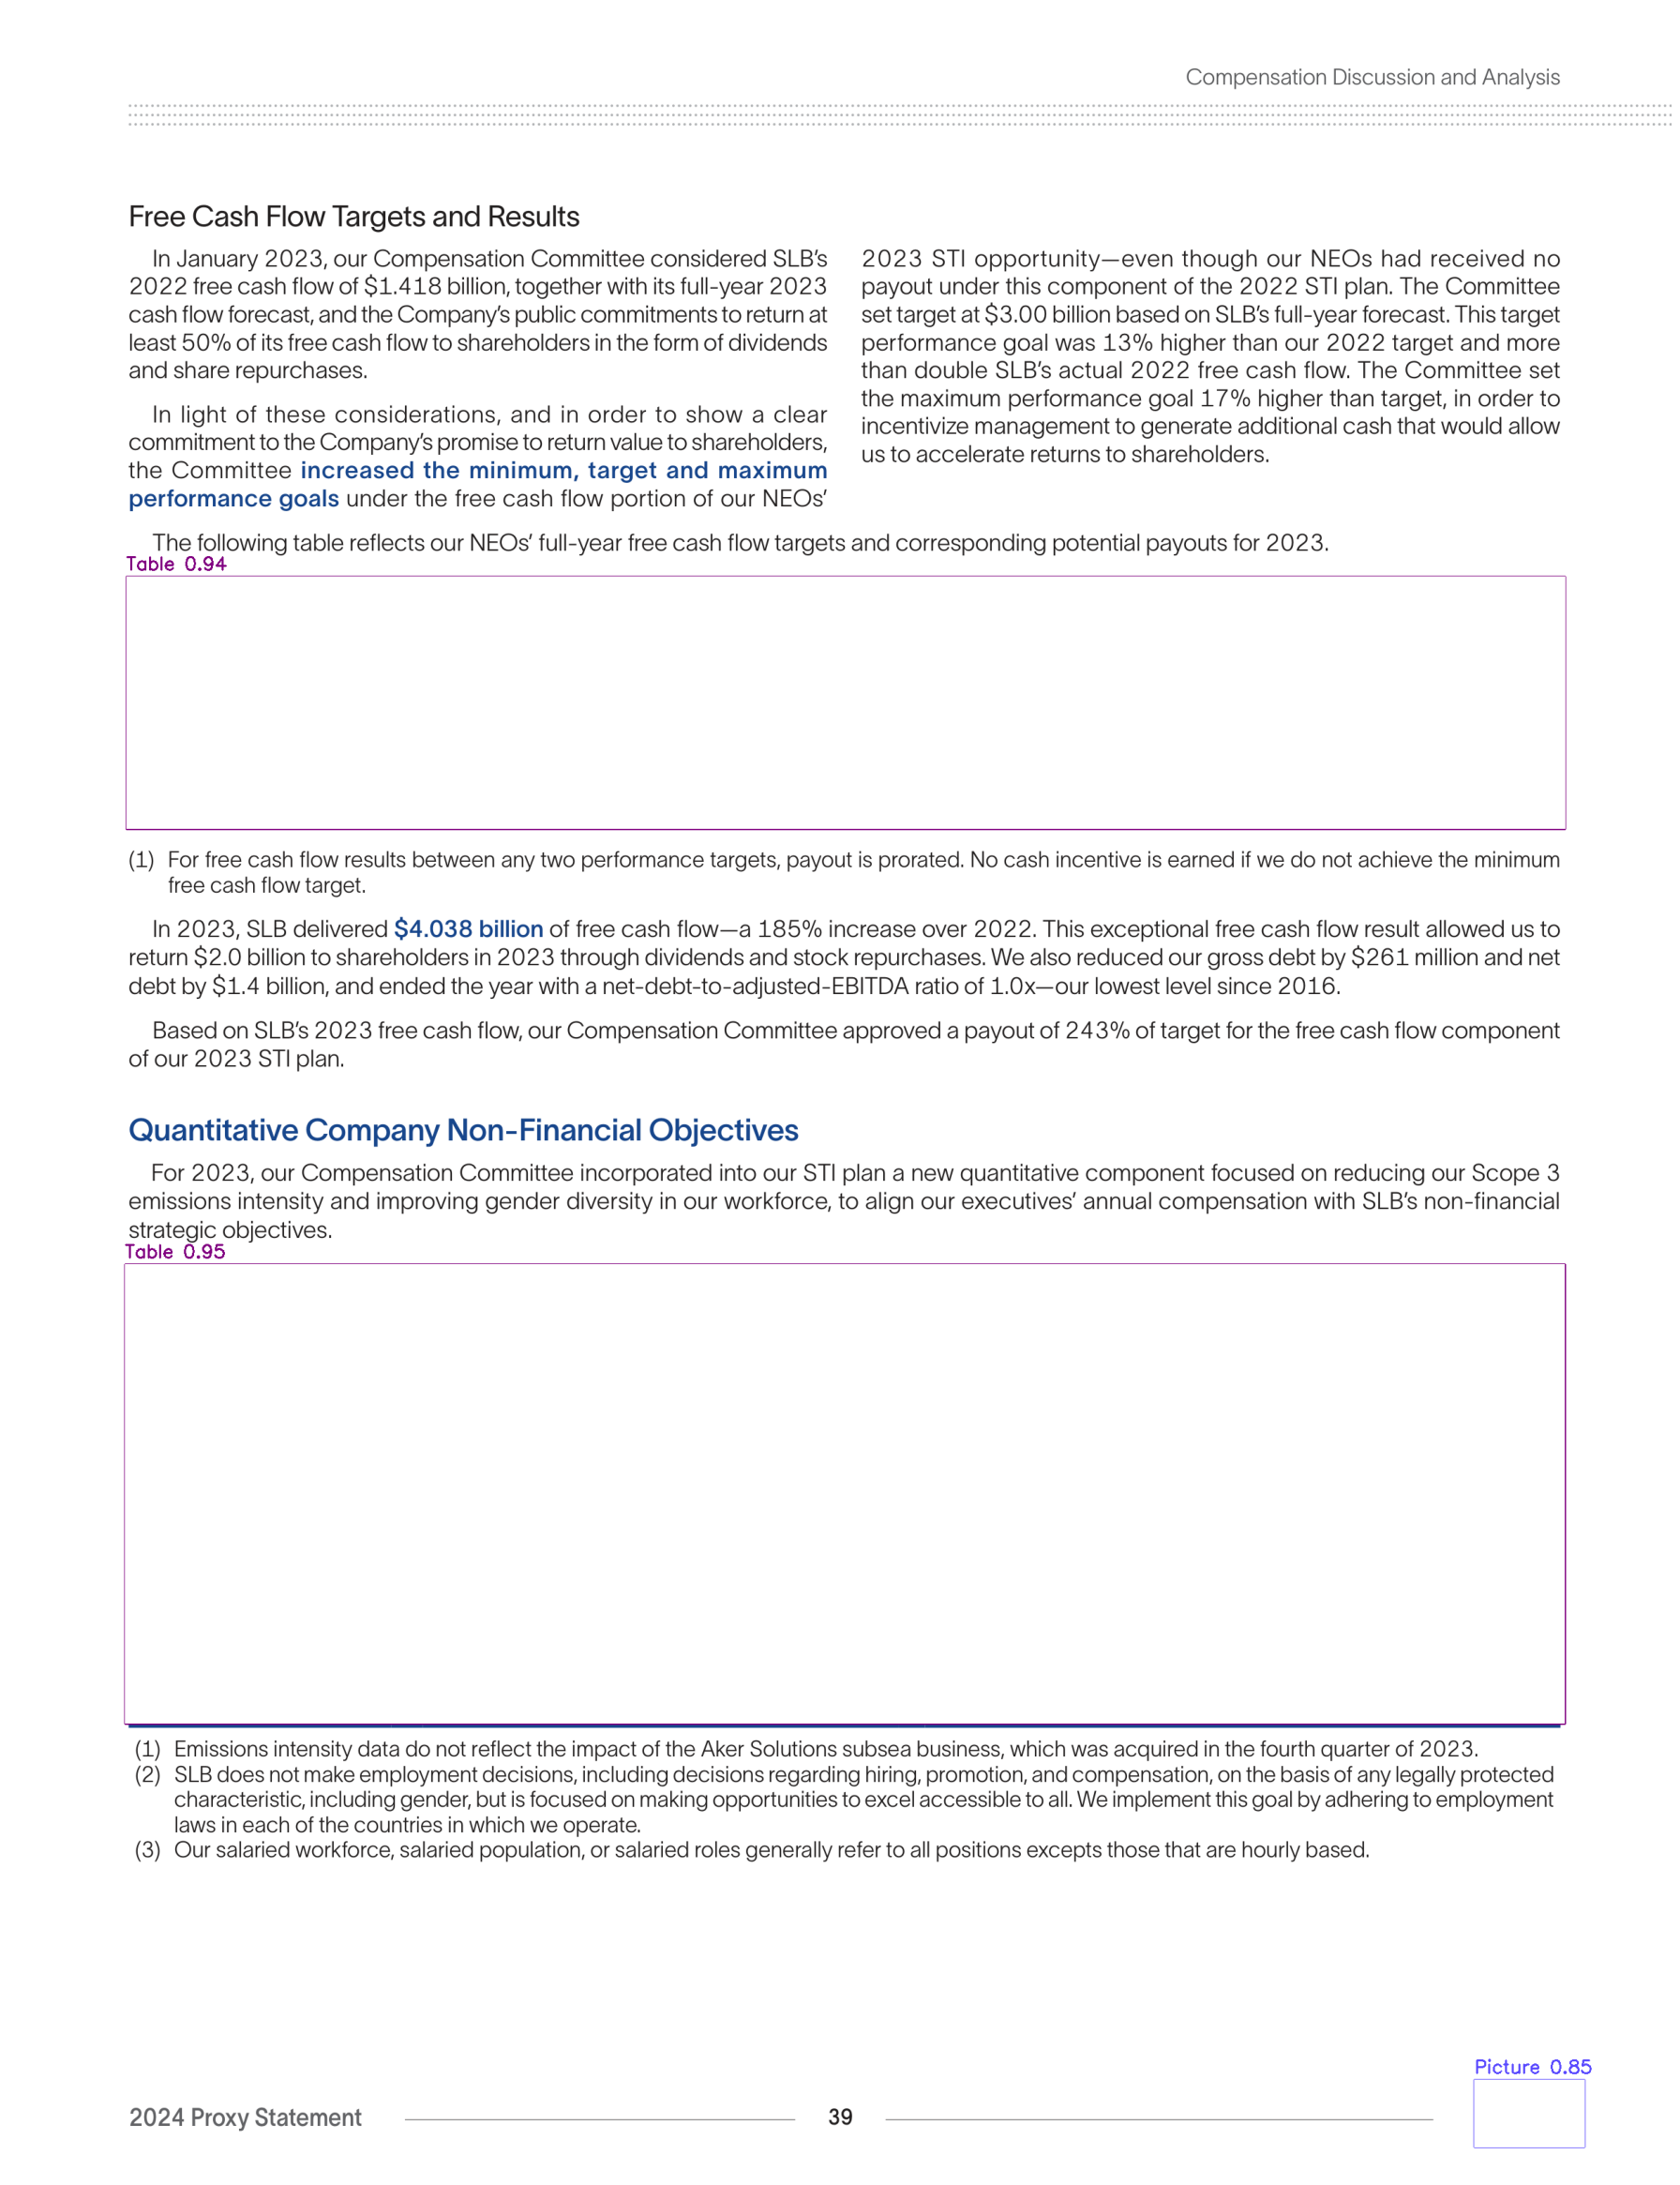

In [15]:
display_img_array(img_page)

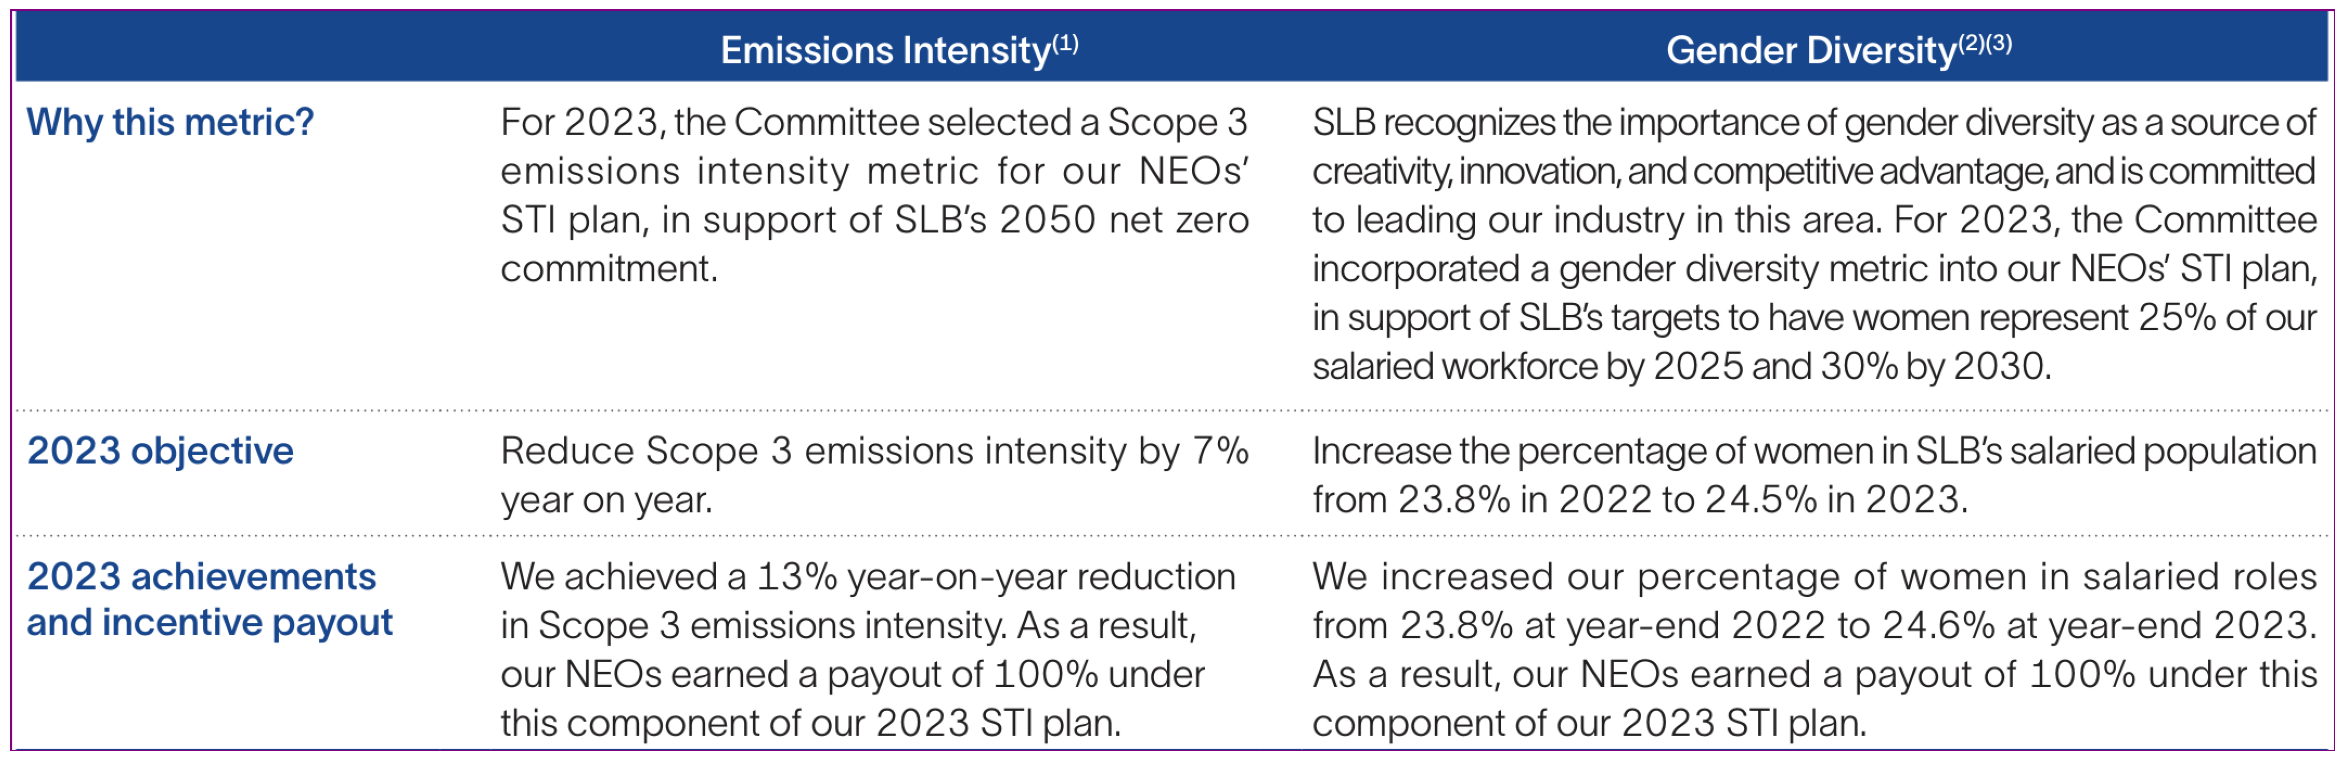

In [16]:
display_img_array(extracted_imgs[0])

##### Save Extracted Images

In [23]:
import os
import cv2

def save_img_files(extracted_imgs, filename, page_id):
    # Target path
    save_path = os.path.join(img_dir, filename, f"page_{page_id}/")
    # Ensure the directory exists
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    # Save the image
    for i in range(len(extracted_imgs)):
        cv2.imwrite(save_path+f"fig_{i}.jpg", extracted_imgs[i])

save_img_files(extracted_imgs, filename, page_id)

##### PyTesseract OCR

In [25]:
import pytesseract

text = pytesseract.image_to_string(img_page)
print(text)

Free Cash Flow Targets and Results

In January 2023, our Compensation Committee considered SLB's
2022 free cash flow of $1.418 billion, together with its full-year 2023
cash flow forecast, and the Company's public commitments to return at
least 50% of its free cash flow to shareholders in the form of dividends
and share repurchases.

In light of these considerations, and in order to show a clear
commitment to the Company's promise to return value to shareholders,
the Committee increased the minimum, target and maximum
performance goals under the free cash flow portion of our NEOs’

Compensation Discussion and Analysis

2023 STI opportunity—even though our NEOs had received no
payout under this component of the 2022 STI plan. The Committee
set target at $3.00 billion based on SLB's full-year forecast. This target
performance goal was 13% higher than our 2022 target and more
than double SLB's actual 2022 free cash flow. The Committee set
the maximum performance goal 17% higher than targe

### Milvus DB

##### Retriever Class

In [ ]:
from pymilvus import MilvusClient, DataType
import numpy as np
import concurrent.futures
import os
import base64

class MilvusColbertRetriever:
    def __init__(self, milvus_client, collection_name, img_dir, dim=128):
        # Initialize the retriever with a Milvus client, collection name, and dimensionality of the vector embeddings.
        # If the collection exists, load it.
        self.collection_name = collection_name
        self.client = milvus_client
        if self.client.has_collection(collection_name=self.collection_name):
            self.client.load_collection(collection_name)
        self.dim = dim
        self.img_dir = img_dir

    def create_collection(self):
        # Create a new collection in Milvus for storing embeddings.
        # Drop the existing collection if it already exists and define the schema for the collection.
        if self.client.has_collection(collection_name=self.collection_name):
            self.client.drop_collection(collection_name=self.collection_name)
        schema = self.client.create_schema(auto_id=True, enable_dynamic_field=True)
        schema.add_field(field_name="pk", datatype=DataType.INT64, is_primary=True)
        schema.add_field(field_name="vector", datatype=DataType.FLOAT_VECTOR, dim=self.dim)
        schema.add_field(field_name="seq_id", datatype=DataType.INT16)
        schema.add_field(field_name="doc_id", datatype=DataType.INT64)
        schema.add_field(field_name="doc", datatype=DataType.VARCHAR, max_length=65535)
        self.client.create_collection(collection_name=self.collection_name, schema=schema)

    def create_index(self):
        # Create an index on the vector field to enable fast similarity search.
        # Releases and drops any existing index before creating a new one with specified parameters.
        self.client.release_collection(collection_name=self.collection_name)
        self.client.drop_index(collection_name=self.collection_name, index_name="vector")
        index_params = self.client.prepare_index_params()
        index_params.add_index(
            field_name="vector",
            index_name="vector_index",
            index_type="IVF_FLAT",  
            metric_type="IP",  
        )
        self.client.create_index(collection_name=self.collection_name, index_params=index_params, sync=True)

    def search(self, data, topk):
        # Perform a vector search on the collection to find the top-k most similar documents.
        search_params = {"metric_type": "IP", "params": {}}
        results = self.client.search(
            self.collection_name,
            data,
            limit=int(50),
            output_fields=["vector", "seq_id", "doc_id","$meta"],
            search_params=search_params,
        )
        doc_meta = {}
        for r_id in range(len(results)):
            for r in range(len(results[r_id])):
                entity = results[r_id][r]["entity"]
                doc_id = entity["doc_id"]
                if doc_id not in doc_meta:
                    doc_meta[doc_id] = {
                        "page_id": entity["page_id"],
                        "fig_id": entity["fig_id"],
                        "filename": entity["filename"],
                    }
        scores = []

        def rerank_single_doc(doc_id, data, client, collection_name):
            # Rerank a single document by retrieving its embeddings and calculating the similarity with the query.
            doc_colbert_vecs = client.query(
                collection_name=collection_name,
                filter=f"doc_id in [{doc_id}]",
                output_fields=["seq_id", "vector", "doc"],
                limit=1000,
            )
            doc_vecs = np.vstack(
                [doc_colbert_vecs[i]["vector"] for i in range(len(doc_colbert_vecs))]
            )
            score = np.dot(data, doc_vecs.T).max(1).sum()
            return (score, doc_id)

        with concurrent.futures.ThreadPoolExecutor(max_workers=300) as executor:
            futures = {
                executor.submit(
                    rerank_single_doc, doc_id, data, self.client, self.collection_name
                ): doc_id
                for doc_id in doc_meta.keys()
            }
            for future in concurrent.futures.as_completed(futures):
                score, doc_id = future.result()
                meta = doc_meta[doc_id]
                img_path = os.path.join(self.img_dir, meta["filename"], f"page_{meta['page_id']}", f"fig_{meta['fig_id']}.jpg")
                with open(img_path, "rb") as f:
                    img_base64 = base64.b64encode(f.read()).decode('utf-8')
                scores.append({
                    "score":float(score), 
                    "page_id": meta["page_id"],
                    "fig_id": meta["fig_id"],
                    "filename": meta["filename"],
                    "content": img_base64})

        scores.sort(key=lambda x: x["score"], reverse=True)
        if len(scores) >= topk:
            return scores[:topk]
        else:
            return scores

    def insert(self, data):
        # Insert ColBERT embeddings and metadata for a document into the collection.
        # Insert the data as multiple vectors (one for each sequence) along with the corresponding metadata.
        colbert_vecs = [vec for vec in data["colbert_vecs"]]
        seq_length = len(colbert_vecs)
        self.client.insert(
            self.collection_name,
            [
                {
                    "vector": colbert_vecs[i],
                    "seq_id": i,
                    "doc_id": data["doc_id"] ,
                    "doc": "",
                    "page_id": data["page_id"],
                    "fig_id": data["fig_id"],
                    "filename": data["filename"],
                }
                for i in range(seq_length)
            ],
        )

class MilvusBasicRetriever:
    def __init__(self, milvus_client, collection_name, dim=1024):
        # Initialize the retriever with a Milvus client, collection name, and dimensionality of the vector embeddings.
        # If the collection exists, load it.
        self.collection_name = collection_name
        self.client = milvus_client
        if self.client.has_collection(collection_name=self.collection_name):
            self.client.load_collection(collection_name)
        self.dim = dim

    def normalize(self, vec):
        # Normalize the vector
        norm = np.linalg.norm(vec)
        if norm == 0:
            return vec
        return vec / norm

    def create_collection(self):
        # Create a new collection in Milvus for storing embeddings.
        # Drop the existing collection if it already exists and define the schema for the collection.
        if self.client.has_collection(collection_name=self.collection_name):
            self.client.drop_collection(collection_name=self.collection_name)
        schema = self.client.create_schema(auto_id=True, enable_dynamic_field=True)
        schema.add_field(field_name="pk", datatype=DataType.INT64, is_primary=True)
        schema.add_field(field_name="vector", datatype=DataType.FLOAT_VECTOR, dim=self.dim)
        schema.add_field(field_name="content", datatype=DataType.VARCHAR, max_length=65535)
        self.client.create_collection(collection_name=self.collection_name, schema=schema)

    def create_index(self):
        # Create an index on the vector field to enable fast similarity search.
        # Releases and drops any existing index before creating a new one with specified parameters.
        self.client.release_collection(collection_name=self.collection_name)
        self.client.drop_index(collection_name=self.collection_name, index_name="vector")
        index_params = self.client.prepare_index_params()
        index_params.add_index(
            field_name="vector",
            index_name="vector_index",
            index_type="IVF_FLAT",  # or any other index type you want
            metric_type="IP",  # or the appropriate metric type
        )
        self.client.create_index(collection_name=self.collection_name, index_params=index_params, sync=True)

    def search(self, data, topk):
        # Perform a vector search on the collection to find the top-k most similar documents.
        normalized_data = self.normalize(data)
        search_params = {"metric_type": "IP", "params": {}}
        results = self.client.search(
            self.collection_name,
            [normalized_data],
            limit=topk,
            output_fields=["vector", "content","$meta"],
            search_params=search_params,
        )
        return_arr = []
        for hit in results[0]:
            return_arr.append({
                "score":hit.distance,
                "page_id":hit["entity"]["page_id"],
                "filename":hit["entity"]["filename"],
                "content":hit["entity"]["content"]
            })
        return return_arr

    def insert(self, data):
        data["vector"] = self.normalize(np.array(data["vector"])).tolist()
        self.client.insert(
            self.collection_name,
            [data]
        )

##### Setup Retriever Client

In [28]:
client = MilvusClient("milvus_file.db")
colbert_retriever = MilvusColbertRetriever(collection_name="colbert", milvus_client=client,img_dir=img_dir)
basic_retriever = MilvusBasicRetriever(collection_name="basic", milvus_client=client)

/mnt/hdd/soohwan/anaconda3/envs/indexing_pipeline/lib/python3.11/site-packages/milvus_lite/__init__.py:15: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


##### Create Data Loader

In [ ]:
from colpali_engine.utils.torch_utils import ListDataset
from torch.utils.data import DataLoader
from typing import List
from tqdm import tqdm
from PIL import Image

def create_image_embedding_loader(extracted_imgs):
    images = [Image.fromarray(img_arr) for img_arr in extracted_imgs]
    dataloader_images = DataLoader(
        dataset=ListDataset[str](images),
        batch_size=1,
        shuffle=False,
        collate_fn=lambda x: processor.process_images(x),
    )
    ds: List[torch.Tensor] = []
    for batch_doc in tqdm(dataloader_images):
        with torch.no_grad():
            batch_doc = {k: v.to(colpali_model.device) for k, v in batch_doc.items()}
            embeddings_doc = colpali_model(**batch_doc)
        ds.extend(list(torch.unbind(embeddings_doc.to("cpu"))))
    return ds

In [30]:
embedding_loader = create_image_embedding_loader(extracted_imgs)
embedding_loader

100%|██████████| 3/3 [00:01<00:00,  2.08it/s]


[tensor([[-0.0055,  0.0991, -0.0903,  ..., -0.0474, -0.0042, -0.1138],
         [-0.0067,  0.1064, -0.0488,  ..., -0.0723,  0.0535, -0.0986],
         [-0.0200,  0.1113, -0.1084,  ..., -0.0747,  0.0447, -0.0786],
         ...,
         [-0.0027,  0.0811, -0.1602,  ...,  0.0354, -0.0112, -0.1670],
         [-0.0557, -0.1099,  0.0128,  ...,  0.0203, -0.0728, -0.0688],
         [ 0.1025,  0.0145, -0.0420,  ...,  0.0894, -0.0413,  0.1650]], dtype=torch.bfloat16),
 tensor([[-0.0055,  0.0991, -0.0903,  ..., -0.0474, -0.0042, -0.1138],
         [-0.0067,  0.1064, -0.0488,  ..., -0.0723,  0.0535, -0.0986],
         [-0.0200,  0.1113, -0.1084,  ..., -0.0747,  0.0447, -0.0786],
         ...,
         [-0.0141,  0.0645, -0.1377,  ...,  0.0430, -0.0061, -0.1338],
         [-0.0835, -0.1094,  0.0049,  ...,  0.0211, -0.0608, -0.0645],
         [ 0.1396,  0.0549, -0.0669,  ...,  0.0942,  0.0038,  0.1514]], dtype=torch.bfloat16),
 tensor([[-0.0053,  0.0996, -0.0894,  ..., -0.0471, -0.0042, -0.1128],
 

##### Indexing images & text to Collection

In [31]:
import random

for i in range(len(extracted_imgs)):
    data = {
        "colbert_vecs": embedding_loader[i].float().numpy(),
        "doc_id": random.getrandbits(63),
        "page_id": page_id,
        "fig_id": i,
        "filename": filename,
    }
    colbert_retriever.insert(data)

In [32]:
data = {
    "vector": embed_model.encode(text),
    "content": text,
    "page_id": page_id,
    "filename": filename
}
basic_retriever.insert(data)

##### Test the Retriever

In [36]:
query = "Potential Payout as a % of Target Opportunity"
batch_query = colpali_processor.process_queries([query]).to(device)
embeddings_query = torch.unbind(colpali_model(**batch_query).to("cpu"))[0].float().numpy()
colbert_retriever_result = colbert_retriever.search(embeddings_query, topk=3)
colbert_retriever_result

[{'score': 16.88633229059633,
  'page_id': 39,
  'fig_id': 0,
  'filename': 'SLB-2023-Annual-Report.pdf',
  'content': '/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAIBAQEBAQIBAQECAgICAgQDAgICAgUEBAMEBgUGBgYFBgYGBwkIBgcJBwYGCAsICQoKCgoKBggLDAsKDAkKCgr/2wBDAQICAgICAgUDAwUKBwYHCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgr/wAARCAFwCFwDASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwD9Hf8Ag4H+KXxN+EH7AX/CXfCb4i694X1b/hN9Ng/tTw7q81lc

In [37]:
query = "Potential Payout as a % of Target Opportunity"
basic_retriever_result = basic_retriever.search(embed_model.encode(query), topk=3)
basic_retriever_result

[{'score': 0.6565427184104919,
  'page_id': 38,
  'filename': 'SLB-2023-Annual-Report.pdf',
  'content': 'Short-Term Cash Incentive Awards\n\nWe pay performance-based short-term (annual) cash incentives to\nour executives to foster a results-driven, pay-for-performance culture,\nand to align executives’ interests with those of our shareholders. STI\nawards are earned according to the achievement of quantitative\nCompany financial and non-financial objectives, as well as strategic\nobjectives. Our Compensation Committee selects performance\nmeasures that it believes support our strategy and strike a balance\nbetween motivating our executives to increase near-term financial and\noperating results and driving profitable long-term Company growth\nand value for shareholders.\n\n2022 STI Opportunity Mix\n\nCompensation Discussion and Analysis\n\nFor 2023, 70% of our NEOs’ target STI opportunity was based on\nachieving quantitative Company financial objectives, 10% was based\non achieving qua